In [1]:
import pickle
import numpy as np
import pandas as pd
import wfdb
# import mne
import os
from matplotlib import pyplot as plt

X_S = pickle.load(open('X_S.pickle', 'rb'))
X_S_file = pickle.load(open('X_S_file.pickle', 'rb'))
X_NS = pickle.load(open('X_S.pickle', 'rb'))
X_NS_file = pickle.load(open('X_NS_file.pickle', 'rb'))
chan_order_dict = pickle.load(open('chan_order_dict.pickle', 'rb'))

In [2]:
# Extract power spec of  5, 10, 15 Hz morlet wavelt of FT9-FT10 for all obs
# This could be refined for better speed by splitting wavelet creation
# into different function/loop. For only a few, it doesn't really matter.

def get_pwr(x,elec,hz):
    # create wavelet
    srate = 256
    time = np.arange(-2,2+1/256,1/256)
    freq = hz

    # gaussian window
    s = 7 / (2*np.pi*freq)
    sine_wave = np.exp(1j*2*np.pi*freq*time)
    gaus_win = np.exp((-time**2) / (2*s**2))
    complex_mw = sine_wave * gaus_win
    
    # Conv parameters
    nData = len(x[chan_order_dict[elec],:])
    nKern = len(complex_mw)
    nConv = nData+nKern-1
    
    # Get FFT of wavelet
    cmwX = np.fft.fft(complex_mw,nConv)
    cmwX = cmwX/max(cmwX)
    
    # Get FFT of data
    dataX = np.fft.fft(x[chan_order_dict[elec],:],nConv)
    
    # Convolution and inverse fft
    conv_res = np.fft.ifft(dataX * cmwX)
    
    # Remove extra ends
    half_wav = round(len(complex_mw)/2)+1
    conv_res_timedomain = conv_res[np.arange(half_wav-1,
                                             len(conv_res)-half_wav+1)]
    
    # Return magnitude squared
    return np.real(conv_res_timedomain)**2+np.imag(conv_res_timedomain)**2
    

In [3]:
# Get 3d array of X_S in correct format
xs_lstm = []
for obs in X_S:
    hz_pwr = []
    for hz in [5,10,15]:
        hz_pwr.append(get_pwr(obs,'FT9-FT10',hz))
    hz_pwr = np.array(hz_pwr).reshape(-1,3)
    xs_lstm.append(hz_pwr)
xs_lstm = np.array(xs_lstm)      

In [4]:
# Get 3d array of X_NS in correct format
xns_lstm = []
for obs in X_NS:
    hz_pwr = []
    for hz in [5,10,15]:
        hz_pwr.append(get_pwr(obs,'FT9-FT10',hz))
    hz_pwr = np.array(hz_pwr).reshape(-1,3)
    xns_lstm.append(hz_pwr)
xns_lstm = np.array(xs_lstm)  

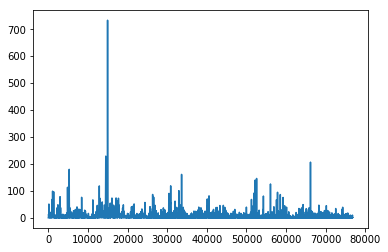

In [5]:
# Plot one example
plt.plot(xs_lstm[0][:,2])

In [6]:
# Combine and shuffle, make Y
np.random.seed(1234)
shuf_int = np.random.choice(range(xs_lstm.shape[0]*2),
                            xs_lstm.shape[0]*2,
                            replace=False)

pre_x = np.concatenate([xs_lstm,xns_lstm])
pre_y = np.concatenate([[1 for i in range(xs_lstm.shape[0])],
                        [0 for i in range(xs_lstm.shape[0])]])
X = pre_x[shuf_int].copy()
Y = pre_y[shuf_int].copy()


In [7]:
# Let's try an LSTM
import keras
from keras import Sequential
from keras.layers import Flatten, Dense, Activation
from keras.layers import Conv2D, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf
import keras.backend as k
from keras.layers import LSTM

Using TensorFlow backend.


In [8]:
# Make managable sized training data (last second, first freq)
# keras_x = np.array([i[-64:,0].reshape(-1,1) for i in X])
keras_x = X.copy()
keras_x[keras_x>100] = 100 # trim excessive
# keras_x = np.log(keras_x)
# Make 16hz sample rate
# keras_x = np.array([i[range(0,i.shape[0],16)] for i in keras_x])

In [15]:
76544+256

76800

In [16]:
[[i,i+256] for i in list(range(0,keras_x.shape[1],256))]

[[0, 256],
 [256, 512],
 [512, 768],
 [768, 1024],
 [1024, 1280],
 [1280, 1536],
 [1536, 1792],
 [1792, 2048],
 [2048, 2304],
 [2304, 2560],
 [2560, 2816],
 [2816, 3072],
 [3072, 3328],
 [3328, 3584],
 [3584, 3840],
 [3840, 4096],
 [4096, 4352],
 [4352, 4608],
 [4608, 4864],
 [4864, 5120],
 [5120, 5376],
 [5376, 5632],
 [5632, 5888],
 [5888, 6144],
 [6144, 6400],
 [6400, 6656],
 [6656, 6912],
 [6912, 7168],
 [7168, 7424],
 [7424, 7680],
 [7680, 7936],
 [7936, 8192],
 [8192, 8448],
 [8448, 8704],
 [8704, 8960],
 [8960, 9216],
 [9216, 9472],
 [9472, 9728],
 [9728, 9984],
 [9984, 10240],
 [10240, 10496],
 [10496, 10752],
 [10752, 11008],
 [11008, 11264],
 [11264, 11520],
 [11520, 11776],
 [11776, 12032],
 [12032, 12288],
 [12288, 12544],
 [12544, 12800],
 [12800, 13056],
 [13056, 13312],
 [13312, 13568],
 [13568, 13824],
 [13824, 14080],
 [14080, 14336],
 [14336, 14592],
 [14592, 14848],
 [14848, 15104],
 [15104, 15360],
 [15360, 15616],
 [15616, 15872],
 [15872, 16128],
 [16128, 16384],


In [36]:
inds = [range(i,i+256) for i in list(range(0,keras_x.shape[1],256))] 
inds[]

range(256, 512)

In [55]:
keras_x = keras.utils.normalize(keras_x,axis=0)
keras_y = keras.utils.to_categorical(Y)

In [56]:
keras_x = np.array([i[-200:,0].reshape(-1,1) for i in X])

In [57]:
np.log(X.max())

12.577653308659698

In [58]:
model = Sequential()
model.add(LSTM(8, input_shape=(keras_x.shape[1:])))
model.add(Dense(2,activation='softmax'))
model.compile(loss='categorical_crossentropy', 
              optimizer=keras.optimizers.adam(),
             metrics=['accuracy'])

In [59]:
model.fit(keras_x,keras_y,batch_size=64,validation_split=.2,epochs=20)

Train on 201 samples, validate on 51 samples
Epoch 1/20
201/201 [==============================] - 2s 10ms/step - loss: 0.7043 - acc: 0.4776 - val_loss: 0.6927 - val_acc: 0.5490
Epoch 2/20
201/201 [==============================] - 1s 3ms/step - loss: 0.6997 - acc: 0.5075 - val_loss: 0.6920 - val_acc: 0.4902
Epoch 3/20
201/201 [==============================] - 1s 3ms/step - loss: 0.6978 - acc: 0.5124 - val_loss: 0.6921 - val_acc: 0.4706
Epoch 4/20
201/201 [==============================] - 1s 3ms/step - loss: 0.6966 - acc: 0.4876 - val_loss: 0.6924 - val_acc: 0.4902
Epoch 5/20
201/201 [==============================] - 1s 3ms/step - loss: 0.6957 - acc: 0.4975 - val_loss: 0.6928 - val_acc: 0.5098
Epoch 6/20
201/201 [==============================] - 1s 3ms/step - loss: 0.6951 - acc: 0.4925 - val_loss: 0.6933 - val_acc: 0.4706
Epoch 7/20
201/201 [==============================] - 1s 3ms/step - loss: 0.6946 - acc: 0.5075 - val_loss: 0.6937 - val_acc: 0.4902
Epoch 8/20
201/201 [==========

In [143]:
list(range(1,10,2))

[1, 3, 5, 7, 9]

In [144]:
256/4

64.0

In [146]:
list(range(0,256,4))

[0,
 4,
 8,
 12,
 16,
 20,
 24,
 28,
 32,
 36,
 40,
 44,
 48,
 52,
 56,
 60,
 64,
 68,
 72,
 76,
 80,
 84,
 88,
 92,
 96,
 100,
 104,
 108,
 112,
 116,
 120,
 124,
 128,
 132,
 136,
 140,
 144,
 148,
 152,
 156,
 160,
 164,
 168,
 172,
 176,
 180,
 184,
 188,
 192,
 196,
 200,
 204,
 208,
 212,
 216,
 220,
 224,
 228,
 232,
 236,
 240,
 244,
 248,
 252]